In [98]:
using OffsetArrays
using Printf
using Plots

In [99]:
############################
# 전역 상수 및 배열 정의
############################

const IDIM = 500
const JDIM = 500

# 실제 계산 격자 크기
const NI  = 101
const NJ  = 101
const NIM = NI - 1
const NJM = NJ - 1

const DX0 = 1.0 / (NI - 1)
const DY0 = 1.0 / (NJ - 1)

const IR  = 0                # 0: Cartesian, 1: Axisymmetric

const K0      = 1.0
const QDOT    = 0.0
const ERRMAX  = 1.0e-6
const T_RELAX = 1.0
const RHO     = 1.0e3
const CP      = 1.0e3

const ITERMAX = 5000
const JUMP    = 10

const U0 = 0.0
const V0 = 1.0e-6

# DOMAIN ARRAYS (0..IDIM-1, 0..JDIM-1)
const XP  = OffsetArray(zeros(Float64, IDIM), 0:IDIM-1)
const XU  = OffsetArray(zeros(Float64, IDIM), 0:IDIM-1)
const YP  = OffsetArray(zeros(Float64, JDIM), 0:JDIM-1)
const YV  = OffsetArray(zeros(Float64, JDIM), 0:JDIM-1)

const DXP = OffsetArray(zeros(Float64, IDIM), 0:IDIM-1)
const DXU = OffsetArray(zeros(Float64, IDIM), 0:IDIM-1)
const DYP = OffsetArray(zeros(Float64, JDIM), 0:JDIM-1)
const DYV = OffsetArray(zeros(Float64, JDIM), 0:JDIM-1)

const RP  = OffsetArray(zeros(Float64, IDIM), 0:IDIM-1)
const RU  = OffsetArray(zeros(Float64, IDIM), 0:IDIM-1)

# FIELD ARRAYS
const T    = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const TSOR = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const BT   = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)

const U    = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const V    = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const USOR = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const VSOR = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const BU   = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const BV   = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)

const TKKP = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const ROCP = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)

# 계수 행렬
const AW  = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const AE  = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const AS  = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const AN  = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const AP  = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const APC = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)

# 보정 및 잔차
const CORR = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)
const RES  = OffsetArray(zeros(Float64, IDIM, JDIM), 0:IDIM-1, 0:JDIM-1)

# 1D work arrays (TDMA & line-by-line)
const SOR_x = zeros(Float64, IDIM)   # i 방향 RHS
const SOR_y = zeros(Float64, JDIM)   # j 방향 RHS
const cwork = zeros(Float64, max(IDIM, JDIM))
const dwork = zeros(Float64, max(IDIM, JDIM))

500-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [100]:
function init!()
    @inbounds begin
        # XU, YV
        for i in 1:NI
            XU[i] = DX0 * (i - 1)
        end
        for j in 1:NJ
            YV[j] = DY0 * (j - 1)
        end

        # XP, YP (staggered)
        for i in 1:NIM
            XP[i] = 0.5 * (XU[i] + XU[i+1])
        end
        for j in 1:NJM
            YP[j] = 0.5 * (YV[j] + YV[j+1])
        end

        XP[0]  = XU[1]
        XP[NI] = XU[NI]
        YP[0]  = YV[1]
        YP[NJ] = YV[NJ]

        # control volume sizes
        for i in 1:NIM
            DXP[i] = XU[i+1] - XU[i]
        end
        for i in 1:NI
            DXU[i] = XP[i] - XP[i-1]
        end

        for j in 1:NJM
            DYP[j] = YV[j+1] - YV[j]
        end
        for j in 1:NJ
            DYV[j] = YP[j] - YP[j-1]
        end

        # face dimensions
        if IR == 0
            for i in 1:NI
                RU[i] = 1.0
            end
            for i in 0:NI
                RP[i] = 1.0
            end
        else
            for i in 1:NI
                RU[i] = abs(XU[i])
            end
            for i in 0:NI
                RP[i] = abs(XP[i])
            end
        end

        # k, rho*cp 기본값
        for i in 0:NI, j in 0:NJ
            TKKP[i,j] = K0
            ROCP[i,j] = RHO * CP
        end

        # 필드 초기화
        for i in 0:NI, j in 0:NJ
            T[i,j]    = 0.0
            TSOR[i,j] = 0.0
            U[i,j]    = 0.0
            V[i,j]    = 0.0
        end
    end
end

init! (generic function with 1 method)

In [101]:
function set_BC!(TW, TE, TS, TN)
    @inbounds begin
        # West / East
        for j in 0:NJ
            T[0,j]  = TW
            T[NI,j] = TE
        end
        # South / North
        for i in 0:NI
            T[i,0]  = TS
            T[i,NJ] = TN
        end
    end
end

function set_NEUMANN!(option::Union{Dict,Nothing}, flag::String)
    option === nothing && return

    @inbounds begin
        if flag == "pre"
            # 계수 행렬에서 Neumann 반영
            for j in 1:NJ-1
                if get(option, :W, "") == "neumann"
                    AP[1,j] -= AW[1,j]
                    AW[1,j] = 0.0
                end
                if get(option, :E, "") == "neumann"
                    AP[NIM,j] -= AE[NIM,j]
                    AE[NIM,j] = 0.0
                end
            end
            for i in 1:NI-1
                if get(option, :S, "") == "neumann"
                    AP[i,1] -= AS[i,1]
                    AS[i,1] = 0.0
                end
                if get(option, :N, "") == "neumann"
                    AP[i,NJM] -= AN[i,NJM]
                    AN[i,NJM] = 0.0
                end
            end
        elseif flag == "post"
            # 해 구한 뒤 ghost cell 에 복사
            for j in 1:NJ-1
                if get(option, :W, "") == "neumann"
                    T[0,j] = T[1,j]
                end
                if get(option, :E, "") == "neumann"
                    T[NI,j] = T[NIM,j]
                end
            end
            for i in 1:NI-1
                if get(option, :S, "") == "neumann"
                    T[i,0] = T[i,1]
                end
                if get(option, :N, "") == "neumann"
                    T[i,NJ] = T[i,NJM]
                end
            end
        end
    end
end

set_NEUMANN! (generic function with 1 method)

In [102]:
# x 방향 한 줄 TDMA: i_start..i_end, 고정 j
function tdma_line_x!(i_start::Int, i_end::Int, j::Int,
                      rhs::AbstractVector{Float64},
                      X::OffsetArray{Float64,2},
                      AW::OffsetArray{Float64,2},
                      AE::OffsetArray{Float64,2},
                      AP::OffsetArray{Float64,2},
                      cwork::Vector{Float64},
                      dwork::Vector{Float64})
    @inbounds begin
        # i = i_start
        a = -AW[i_start,j]
        c = -AE[i_start,j]
        b =  AP[i_start,j]

        cwork[i_start] = c / b
        dwork[i_start] = rhs[i_start] / b

        # forward
        for i in (i_start+1):i_end
            a = -AW[i,j]
            c = -AE[i,j]
            b =  AP[i,j]
            denom = b - a * cwork[i-1]
            cwork[i] = c / denom
            dwork[i] = (rhs[i] - a * dwork[i-1]) / denom
        end

        # backward
        X[i_end,j] = dwork[i_end]
        for i in (i_end-1):-1:i_start
            X[i,j] = dwork[i] - cwork[i] * X[i+1,j]
        end
    end
    return nothing
end

# y 방향 한 줄 TDMA: j_start..j_end, 고정 i
function tdma_line_y!(j_start::Int, j_end::Int, i::Int,
                      rhs::AbstractVector{Float64},
                      X::OffsetArray{Float64,2},
                      AS::OffsetArray{Float64,2},
                      AN::OffsetArray{Float64,2},
                      AP::OffsetArray{Float64,2},
                      cwork::Vector{Float64},
                      dwork::Vector{Float64})
    @inbounds begin
        # j = j_start
        a = -AS[i,j_start]
        c = -AN[i,j_start]
        b =  AP[i,j_start]

        cwork[j_start] = c / b
        dwork[j_start] = rhs[j_start] / b

        # forward
        for j in (j_start+1):j_end
            a = -AS[i,j]
            c = -AN[i,j]
            b =  AP[i,j]
            denom = b - a * cwork[j-1]
            cwork[j] = c / denom
            dwork[j] = (rhs[j] - a * dwork[j-1]) / denom
        end

        # backward
        X[i,j_end] = dwork[j_end]
        for j in (j_end-1):-1:j_start
            X[i,j] = dwork[j] - cwork[j] * X[i,j+1]
        end
    end
    return nothing
end

# Line-by-line TDMA (2-pass: x-sweep, y-sweep)
function lltdma!(i_start::Int, i_end::Int,
                 j_start::Int, j_end::Int,
                 AW::OffsetArray{Float64,2},
                 AE::OffsetArray{Float64,2},
                 AS::OffsetArray{Float64,2},
                 AN::OffsetArray{Float64,2},
                 AP::OffsetArray{Float64,2},
                 SOR::OffsetArray{Float64,2},
                 X::OffsetArray{Float64,2})
    @inbounds begin
        for it in 1:2
            # 1) x-direction sweep
            for j in j_start:j_end
                for i in i_start:i_end
                    neighbors = AS[i,j] * X[i, j-1] + AN[i,j] * X[i, j+1]
                    SOR_x[i] = SOR[i,j] + neighbors
                end
                tdma_line_x!(i_start, i_end, j, SOR_x, X, AW, AE, AP, cwork, dwork)
            end

            # 2) y-direction sweep
            for i in i_start:i_end
                for j in j_start:j_end
                    neighbors = AW[i,j] * X[i-1, j] + AE[i,j] * X[i+1, j]
                    SOR_y[j] = SOR[i,j] + neighbors
                end
                tdma_line_y!(j_start, j_end, i, SOR_y, X, AS, AN, AP, cwork, dwork)
            end
        end
    end
    return nothing
end

lltdma! (generic function with 1 method)

In [103]:
@inline function minmod(a::Float64, b::Float64)
    a * b <= 0.0 && return 0.0
    a < 0.0 ? max(a, b) : min(a, b)
end

@inline function get_upwind(i::Int, j::Int, dim::Symbol)
    if dim === :x
        return U[i,j] >= 0.0 ? (i, j) : (i+1, j)
    elseif dim === :y
        return V[i,j] >= 0.0 ? (i, j) : (i, j+1)
    else
        error("dim must be :x or :y")
    end
end

# 경계에서 인덱스가 음수로 가지 않도록 clamp 처리
@inline function get_faceVal(i::Int, j::Int, dim::Symbol)
    @inbounds begin
        ui, uj = get_upwind(i, j, dim)
        if dim === :x
            ip = min(ui + 1, NI)
            im = max(ui - 1, 0)
            r_diff = T[ip, uj] - T[ui, uj]
            l_diff = T[ui, uj] - T[im, uj]
        else
            jp = min(uj + 1, NJ)
            jm = max(uj - 1, 0)
            r_diff = T[ui, jp] - T[ui, uj]
            l_diff = T[ui, uj] - T[ui, jm]
        end
        diff = minmod(r_diff, l_diff)
        sign = (-1.0) ^ ((ui - i) + (uj - j))
        return T[ui,uj] + 0.5 * sign * diff
    end
end

get_faceVal (generic function with 1 method)

In [104]:
function get_RES!()
    resmax = 0.0
    ffmax  = 0.0
    fcmax  = 0.0

    @inbounds for i in 1:NIM, j in 1:NJM
        # face flux
        flux_W = RHO * CP * RU[i]   * DYP[j] * U[i,j]
        flux_E = RHO * CP * RU[i+1] * DYP[j] * U[i+1,j]
        flux_S = RHO * CP * RP[i]   * DXP[i] * V[i,j]
        flux_N = RHO * CP * RP[i]   * DXP[i] * V[i,j+1]

        # diffusion (FOU implicit part)
        neighbors =
            AW[i,j] * T[i-1,j] +
            AE[i,j] * T[i+1,j] +
            AS[i,j] * T[i,j-1] +
            AN[i,j] * T[i,j+1]

        fou = AP[i,j] * T[i,j] - neighbors

        # SOU convection (MUSCL)
        x_conv_SOU = flux_E * get_faceVal(i, j, :x) -
                     flux_W * get_faceVal(i-1, j, :x)
        y_conv_SOU = flux_N * get_faceVal(i, j, :y) -
                     flux_S * get_faceVal(i, j-1, :y)

        # FOU convection (1st order upwind)
        x_conv_FOU =
            (max(0.0, flux_E) * T[i,j]   + max(0.0, -flux_E) * T[i+1,j]) -
            (max(0.0, flux_W) * T[i-1,j] + max(0.0, -flux_W) * T[i,j])

        y_conv_FOU =
            (max(0.0, flux_N) * T[i,j]   + max(0.0, -flux_N) * T[i,j+1]) -
            (max(0.0, flux_S) * T[i,j-1] + max(0.0, -flux_S) * T[i,j])

        x_conv = x_conv_SOU - x_conv_FOU
        y_conv = y_conv_SOU - y_conv_FOU
        conv   = x_conv + y_conv

        sou = fou + conv

        RES[i,j] = TSOR[i,j] - sou

        resmax = max(resmax, abs(RES[i,j] / AP[i,j]))
        ffmax  = max(ffmax, abs(T[i,j]))
        fcmax  = max(fcmax, abs(CORR[i,j]))
    end

    ffmax  = max(ffmax, 1.0e-30)
    resmax = resmax / ffmax
    fcmax  = fcmax / ffmax

    return resmax, ffmax, fcmax
end

function monitor_RES(iter::Int, resmax::Float64, fcmax::Float64)
    is_continue = true
    if iter % JUMP == 0
        @printf(" iter= %4d T= %11.3e ResMax= %11.3e FcMax= %11.3e\n",
                iter, T[NI÷2, NJ÷2], resmax, fcmax)
    end
    if iter > 0 && resmax < ERRMAX && fcmax < ERRMAX
        @printf(" iter= %4d T= %11.3e ResMax= %11.3e FcMax= %11.3e\n",
                iter, T[NI÷2, NJ÷2], resmax, fcmax)
        is_continue = false
    end
    return is_continue
end

monitor_RES (generic function with 1 method)

In [105]:
function solve_T!(option::Union{Dict,Nothing}=nothing)
    @inbounds begin
        # 계수 조립 (FOU + diffusion)
        for i in 1:NIM, j in 1:NJM
            kw = K0    # TKK_INTP 생략: 상수 k
            ke = K0
            ks = K0
            kn = K0

            _AW = kw * RU[i]   * DYP[j] / DXU[i]
            _AE = ke * RU[i+1] * DYP[j] / DXU[i+1]
            _AS = ks * RP[i]   * DXP[i] / DYV[j]
            _AN = kn * RP[i]   * DXP[i] / DYV[j+1]

            # FOU implicit
            flux_W = RHO * CP * RU[i]   * DYP[j] * U[i,j]
            flux_E = RHO * CP * RU[i+1] * DYP[j] * U[i+1,j]
            flux_S = RHO * CP * RP[i]   * DXP[i] * V[i,j]
            flux_N = RHO * CP * RP[i]   * DXP[i] * V[i,j+1]

            AW[i,j] = _AW + max(0.0,  flux_W)
            AE[i,j] = _AE + max(0.0, -flux_E)
            AS[i,j] = _AS + max(0.0,  flux_S)
            AN[i,j] = _AN + max(0.0, -flux_N)
            AP[i,j] = AW[i,j] + AE[i,j] + AS[i,j] + AN[i,j]

            TSOR[i,j] = QDOT * RP[i] * DXP[i] * DYP[j]
        end
    end

    # Neumann BC 미리 계수에 반영
    set_NEUMANN!(option, "pre")

    # Iteration
    for iter in 0:ITERMAX
        resmax, ffmax, fcmax = get_RES!()
        if !monitor_RES(iter, resmax, fcmax)
            break
        end

        # CORR = 0으로 시작
        @inbounds for i in 0:NI, j in 0:NJ
            CORR[i,j] = 0.0
        end

        # Line-by-line solve: AP * CORR ≈ RES
        lltdma!(1, NIM, 1, NJM, AW, AE, AS, AN, AP, RES, CORR)

        # T 업데이트
        @inbounds for i in 1:NIM, j in 1:NJM
            T[i,j] += T_RELAX * CORR[i,j]
        end

        # Neumann BC 후처리
        set_NEUMANN!(option, "post")
    end

    return T
end

solve_T! (generic function with 2 methods)

In [106]:
using Measures

function plot_results(input_T)

    x_coords = [XP[i] for i in 1:NIM]
    y_coords = [YP[j] for j in 1:NJM]

    T_data = Array{Float64}(undef, NIM, NJM)
    @inbounds for i in 1:NIM, j in 1:NJM
        T_data[i,j] = input_T[i,j]
    end

    plt = contourf(
        x_coords, 
        y_coords, 
        T_data',                 # (x,y) 순서 맞기 위해 transpose
        title         = "Temperature Distribution ($(NIM)x$(NJM) Grid)",
        xlabel        = "X",
        ylabel        = "Y",
        aspect_ratio  = :equal,
        colorbar      = true,
        levels        = 15,
        c             = :turbo,   # ★ 파랑→빨강 계열 (추천)
        size          = (600, 600),
        margin        = 0mm,
        left_margin   = 0mm,
        right_margin  = 0mm,
        bottom_margin = 0mm,
        top_margin    = 0mm
    )

    contour!(
        x_coords, 
        y_coords, 
        T_data',
        c = :black,
        lw = 0.5,
        levels = 15
    )

    display(plt)
end


plot_results (generic function with 1 method)

---------------Case 1: TW=0, TE=0, TS=0, TN=1---------------
 iter=    0 T=   0.000e+00 ResMax=   4.988e+29 FcMax=   0.000e+00
 iter=   10 T=   4.977e-09 ResMax=   2.333e-03 FcMax=   2.776e-02
 iter=   20 T=   1.968e-05 ResMax=   1.115e-03 FcMax=   1.270e-02
 iter=   30 T=   5.040e-04 ResMax=   7.251e-04 FcMax=   8.142e-03
 iter=   40 T=   2.631e-03 ResMax=   5.338e-04 FcMax=   5.943e-03
 iter=   50 T=   7.118e-03 ResMax=   4.207e-04 FcMax=   4.660e-03
 iter=   60 T=   1.386e-02 ResMax=   3.461e-04 FcMax=   3.821e-03
 iter=   70 T=   2.237e-02 ResMax=   2.932e-04 FcMax=   3.229e-03
 iter=   80 T=   3.211e-02 ResMax=   2.540e-04 FcMax=   2.790e-03
 iter=   90 T=   4.262e-02 ResMax=   2.236e-04 FcMax=   2.452e-03
 iter=  100 T=   5.356e-02 ResMax=   1.994e-04 FcMax=   2.184e-03
 iter=  110 T=   6.468e-02 ResMax=   1.798e-04 FcMax=   1.967e-03
 iter=  120 T=   7.579e-02 ResMax=   1.635e-04 FcMax=   1.787e-03
 iter=  130 T=   8.677e-02 ResMax=   1.498e-04 FcMax=   1.635e-03
 iter=  140 T= 

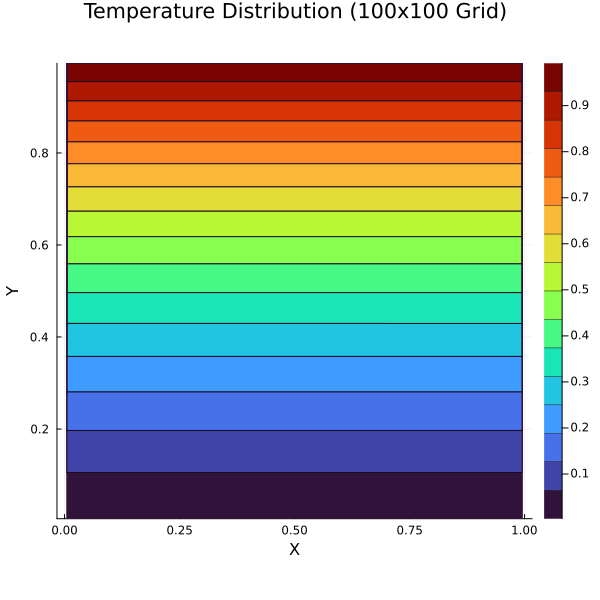

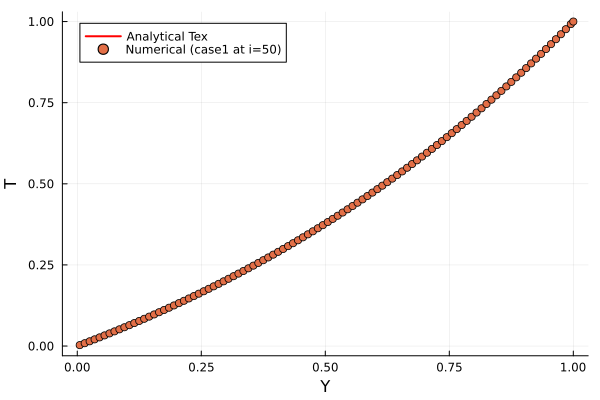

In [107]:
println("---------------Case 1: TW=0, TE=0, TS=0, TN=1---------------")

init!()

# 속도장 설정
@inbounds for i in 0:NI, j in 0:NJ
    U[i,j] = U0
    V[i,j] = V0
end

# Dirichlet BC
set_BC!(0.0, 0.0, 0.0, 1.0)

# 동서 Neumann, 남북 Dirichlet
case1 = solve_T!(Dict(:E=>"neumann", :W=>"neumann"))

println("------------------------------------------------------------")
plot_results(case1)

Pe = RHO * CP * V0 * (YP[NJ] - YP[0]) / K0

Tex = OffsetArray(zeros(Float64, JDIM), 0:JDIM-1)
@inbounds for j in 0:NJ
    Tex[j] = (exp(Pe * YP[j]) - 1.0) / (exp(Pe) - 1.0)
end

mid_i = NI ÷ 2

plt1 = plot(
    YP[0:NJ], Tex[0:NJ],
    label = "Analytical Tex",
    c     = :red,
    lw    = 2,
)

plot!(
    plt1,
    YP[1:NJ], [case1[mid_i, j] for j in 1:NJ],
    seriestype = :scatter,
    label      = "Numerical (case1 at i=$(mid_i))",
    ms         = 4,
)

xlabel!("Y")
ylabel!("T")
display(plt1)
